#### Functions Group

##### **Info**

***01.04.2025 by Roland Bolboaca***

1. **Dataset link:** 

    - Information about the first atasets, namely San Francisco(Caltrain) and Sao Bento(Porto).
        - Link: https://github.com/bguillouet/trajectory_classification

    - Download:

        - San Francisco Dataset: https://ieee-dataport.org/open-access/crawdad-epflmobility 

        - Porto Dataset: https://archive.ics.uci.edu/dataset/339/taxi+service+trajectory+prediction+challenge+ecml+pkdd+2015 

        - Multiple Datasets: https://dl.acm.org/doi/fullHtml/10.1145/3355283 (Table 3)

2. **Teri Preprocessed Dataset:** 
    
    - Pkl Files: 
        - datasets/porto_trajectories.pkl and porto_uci_31k_traj.pkl
        - This dataset contains a list of pandas dataframes.
        - Each datafarme contains a trajectory with 2 features (lat, lon) for now.

3. **Directories:**

    - Datasets: holds the datasets as pkl files.
    - Pkls: holds the results as pkl files (S2S and P2P, SL, HU, COMP)
    - Plots: holds the plots for the results.

4. **Flow:**

    - Create and activate venv: .\venv\Scripts\activate  
    - Check and install requirements.txt: pip install -r requirements.txt

    - Set parameters and Hyperparameters below.
    - Load Trajectory Data:
        - Load from pkl.
        - Select only trajectories from the defined square.
        - Select only the needed number of trajectories.
        - Get mins and maxs (for manual norm/denorm).
        - Create X and Y from data.
    - Create Train/Test splits:
        - Train data preparation.
        - Test data preparation.
            - Can be performed with additional testing file or by splitting a single file into train/test.
        - For each trajectory, the values are padded (end) with zeroes to a multiple of the SL (for data reshaping).
        - After inference, the padded vcalues are removed.
    - Testing flow:
        - Create LSTM/RNN/GRU models
        - Train models.
        - Test Models.
        - Compute model metrics: SE, IE, and MSE.
        - Denormalize data.
        - Plot results.

5. **Included full experiments:**
    
    - **Dynamic Sequence Length (SL):**
        - Train with a given SL, which defults to 25.
        - Test with a batch size of 1 and a SL of 25.
        - Test with a batch size of 1 and a SL of 1.
            - Can run inference in real time even with a single point.
        - Almost identical results for the above two experiments.
        - Denormalize, compute metrics, plot.
        - Save results.

    - **SL performance analysis:**
        - Train with SLs between 3 and 40 with an increasing step of 3.
        - Test with the same SLs and a batch size of 1.
        - Denormalize, compute metrics, plot.
        - Save results.

    - **Hidden Units (HU) performance analysis:**
        - Train with various number of HU, ranging from 2 to 64.
        - Test with the same number of HU.
        - Denormalize, compute metrics, plot.
        - Save results.

    - **LSTM, GRU, RNN model performance analysis:**
        - Train and test the performance of the three models.
        - Denormalize, compute metrics, plot.
        - Save results.

    - **Keras training approach or manual training loop with sequence reset:**
        - Train and test the performance of both models.
        - Denormalize, compute metrics, plot.
        - Analyse results.
        

Feel free to change and enhance the code!

##### **Module Imports**

In [39]:
import os
# oneDNN warning suppression TF 2.4.1
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
import copy
import math

import keras
import tensorflow as tf
from keras import Sequential

import numpy as np
import pandas as pd

import pickle
import gc
from ipywidgets import *
import matplotlib.pyplot as plt


from urllib.request import urlretrieve
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

from scipy.stats import energy_distance, wasserstein_distance
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from math import radians
from sklearn.metrics.pairwise import haversine_distances

%matplotlib widget

##### **Parameters**

In [40]:
# SEED = 837

SEED = 123456
TESTING_SIZE = 0.2

# Total number of trajectories. If set to 0, all trajectories are used
TOTAL_TRAJS = 0

TRAINING_TESTING_SAME_FILE = True

SELECTED_DATASET = "SANFRANCISCO" 
# SELECTED_DATASET = "PORTO"  


# DATASET = {"PORTO": "datasets/Porto/porto_uci_31k_traj_drop_only.pkl",
#            "SANFRANCISCO": "datasets/San_Francisco/train_trajectories.pkl"}


DATASET = {"PORTO": "datasets/Porto/porto_uci_31k_traj_time_diff.pkl",
           "SANFRANCISCO": "datasets/San_Francisco/train_trajectories_time_diff.pkl"}

TESTING_FILE = None

# COLUMNS = ["lat", "lon"]
           
COLUMNS = ["lat", "lon", "distance_km", "speed_km"]

COLUMNS_INPUT = ["lat", "lon", "speed_km"]
COLUMNS_OUTPUT = ["lat", "lon"]

# COLUMNS = ["lat", "lon", "distance_km"]

# COLUMNS = ["lat", "lon", "distance_km", "speed_km"]



DATA_SQUARE_SF = { 
                "lat_1": 37.86499,
                "lon_1": -122.53304,
                "lat_2": 37.68481,
                "lon_2": -122.30576
                }

DATA_SQUARE_PORTO = { 
                "lon_1": 41.23969,
                "lat_1": -8.73005,
                "lon_2": 41.05951,
                "lat_2": -8.49195
                }

DATA_SQUARE = {"SANFRANCISCO": DATA_SQUARE_SF,
               "PORTO": DATA_SQUARE_PORTO}

DATA_CENTER_PORTO = {
    "lat": 41.14961, # Latitude of Porto
    "lon": -8.61099 # Longitude of Porto
}

DATA_CENTER_SF = {
    "lat": 37.7749,  # Latitude of San Francisco
    "lon": -122.4194  # Longitude of San Francisco
}


##### **Hyperparameters**

In [41]:
LSTM_CELLS = 32 #32
SEQ_LEN = 25 #25
BATCH_SIZE = 32 #32
EPOCHS = 100
LR = 0.01

STATEFUL = False
RETURN_SEQ = True

NUM_FEATS = 3
NUM_OUTPUTS = 2

FEATS = [0, 1, 2] # lat, lon, speed_km
OUTPUTS = [0, 1] # lat, lon


##### **Data Loading**

In [42]:
def save_pickle(data, data_path):
    """ Save data to a pickle file """
    
    with open(data_path, 'wb') as f:
        pickle.dump(data, f)

In [43]:
def load_pickle(data_path):
    """ Load data from file path"""
    
    with open(data_path, 'rb') as f:
        df = pickle.load(f)
    
    return df

In [44]:
def load_data_from_pickle(data_path, num_of_traj = 0):
    """ Load data from pickle file """
    
    df = load_pickle(data_path)
    
    if num_of_traj != 0:
        num_of_traj = len(df)
        df = df[:num_of_traj]
    
    return df

In [45]:
def create_X_Y_from_data(data, num_of_traj):
    """
        Create X and Y from the data.
        X is composed of the trajectory data starting from the first point to the second last point
        Y is composed of the trajectory data starting from the second point to the last point
        Keeps only the selected COLUMNS (defined in the parameters block)
    """
    X, Y = [0.0]  * num_of_traj, [0.0] * num_of_traj


    for i in range(num_of_traj):
        # X is composed of the trajectory data starting from the first point to the second last point
        X[i] =  data[i][COLUMNS_INPUT].iloc[0:-1] 
        X[i] = X[i].fillna(0)
        X[i].columns = COLUMNS_INPUT

        # Y is composed of the trajectory data starting from the second point to the last point
        Y[i] =  data[i][COLUMNS_OUTPUT].iloc[1:] 
        Y[i] = Y[i].fillna(0)
        Y[i].columns = COLUMNS_OUTPUT
        
        X[i] = X[i].to_numpy()
        Y[i] = Y[i].to_numpy()
        
    return X, Y

In [46]:
def load_dummy_data():
    """ Dummy Dataset Load for custom experiments"""
    
    uri = "https://archive.ics.uci.edu/ml/machine-learning-databases/00616/Tetuan%20City%20power%20consumption.csv"
    keras.utils.get_file("ds.csv","https://archive.ics.uci.edu/ml/machine-learning-databases/00616/Tetuan%20City%20power%20consumption.csv" )
    filename = "ds.csv"
    urlretrieve(uri, filename)

    data_df = pd.read_csv("ds.csv")
    data_df["DateTime"] = pd.to_datetime(data_df["DateTime"])
    data_df = data_df.set_index('DateTime')
    data_df.columns = [col.strip() for col in data_df.columns]

    return data_df

##### **Data preprocessing, Normalization and Scaling**

In [47]:
def get_data_in_square(data, square):
    """ Get data inside the square defined by the square dictionary """ 
    
    # Ensure correct bounds regardless of coordinate sign or order
    lat_min = min(square["lat_1"], square["lat_2"])
    lat_max = max(square["lat_1"], square["lat_2"])
    lon_min = min(square["lon_1"], square["lon_2"])
    lon_max = max(square["lon_1"], square["lon_2"])

    filtered_data = []
    
    for traj in data:
        in_lat_bounds = traj["lat"].between(lat_min, lat_max)
        in_lon_bounds = traj["lon"].between(lon_min, lon_max)

        if (in_lat_bounds & in_lon_bounds).all():
            filtered_data.append(traj)
            
            
    return filtered_data

In [48]:
def get_min_max_from_data(data):
    # Get trajectories min and max values
    num_of_traj = len(data)
    mins, maxs = [0.0] * num_of_traj, [0.0] * num_of_traj

    for i in range(num_of_traj):
        mins[i]  = np.array(data[i].min()) 
        maxs[i] = np.array(data[i].max()) 

    mins =  np.min( np.array(mins), axis = 0)[0 : 2]
    maxs =  np.max( np.array(maxs), axis = 0)[0 : 2]
    
    return mins, maxs

In [49]:
def normalize_data(dataset, 
                   normalization_type = 'min-max',
                   normalization_ranges = None,
                   testing_data_norm = False):
    """
        Function to normalize the dataset using either min-max or standard normalization.
        Can be used for separate testing data normalization or for normalization of the whole dataset with other ranges.
        Returns the normalized dataset.
    """
    
    if normalization_type == 'min-max':   
        scaler = MinMaxScaler()
    elif normalization_type == 'standard':
        scaler = StandardScaler()
    
    # Normalize the dataset using the ranges given in normalization_ranges (min and max)        
    # Used for separate testing data normalization or for normalization of the whole dataset with other ranges
    
    if normalization_ranges is not None:
        scaler.min = normalization_ranges["min"]
        scaler.max = normalization_ranges["max"]
    else:
        scaler.fit(dataset)
        
    columns = dataset.columns
    
    norm_dataset = scaler.transform(dataset)
    norm_dataset = pd.DataFrame(norm_dataset, columns = columns)
    
    return scaler, norm_dataset


In [50]:
def normalize_trajectory_data(dataset, 
                   normalization_type = 'min-max',
                   normalization_ranges = None,
                   testing_data_norm = False,
                   scaler = None):
    """
        Function to normalize the dataset using either min-max or standard normalization.
        Can be used for separate testing data normalization or for normalization of the whole dataset with other ranges.
        Returns the normalized dataset.
    """
    dataset_cpy = copy.deepcopy(dataset)
    
    if testing_data_norm is False:
        if scaler is None:
            if normalization_type == 'min-max':   
                scaler = MinMaxScaler()
            elif normalization_type == 'standard':
                scaler = StandardScaler()
        
        # Normalize the dataset using the ranges given in normalization_ranges (min and max)        
        # Used for separate testing data normalization or for normalization of the whole dataset with other ranges
        
        if normalization_ranges is not None:
            X_min = normalization_ranges["min"]
            X_max = normalization_ranges["max"]
            dataset_cpy = [(arr - X_min) / (X_max - X_min) for arr in dataset_cpy]
            
        else:
            dataset_flat = pd.concat(dataset_cpy, ignore_index=True)
            # dataset_flat = np.vstack(dataset_cpy)
            scaler.fit(dataset_flat)
            
            columns = dataset_cpy[0].columns
            
            for i in range(len(dataset_cpy)):
                norm_dataset = scaler.transform(dataset_cpy[i])
                norm_dataset = pd.DataFrame(norm_dataset, columns = columns)
                dataset_cpy[i] = norm_dataset
        
    else:
        
        if normalization_ranges is not None:
            X_min = normalization_ranges["min"]
            X_max = normalization_ranges["max"]
            dataset_cpy = [(arr - X_min) / (X_max - X_min) for arr in dataset_cpy]
            
        else:
            columns = dataset_cpy[0].columns
        
            for i in range(len(dataset_cpy)):
                norm_dataset = scaler.transform(dataset_cpy[i])
                norm_dataset = pd.DataFrame(norm_dataset, columns = columns)
                dataset_cpy[i] = norm_dataset
            
    return scaler, dataset_cpy

##### **Denormalize Data**

In [51]:
def denormalize_data(dataset, scaler = None, normalization_ranges = None):
    """
        Function to denormalize the dataset using the scaler used to normalize the dataset.
        Manual denormalization can be used for separate testing data denormalization or for denormalization of the whole dataset.
    """
    dataset_cpy = copy.deepcopy(dataset)
    
    #######
    if scaler is None and normalization_ranges is not None:
        X_min = normalization_ranges["min"]
        X_max = normalization_ranges["max"]
        
        dataset_cpy = [arr * (X_max - X_min) + X_min for arr in dataset]
            
    if scaler is not None:
        for item in range(len(dataset)):
            dataset_cpy[item] = scaler.inverse_transform(dataset_cpy[item])
       
    return dataset_cpy

##### **Data preparation**

In [52]:
def train_reshape(X, Y, 
                seq_len,
                num_feats, 
                num_outputs,
                batch_size):
    """
        Function to split the data into training and testing sets and reshape the data into the required shape for the LSTM model
        Returns a dictionary with the following:
            X_train: Training data for the input features
            X_test: Testing data for the input features
            Y_train: Training data for the output features
            Y_test: Testing data for the output features    
    """
    
    valid_rows = X.shape[0] // seq_len * seq_len

    if len(Y.shape) == 1:
        X = X[:valid_rows]
        Y = Y[:valid_rows]
    else:
        X = X[:valid_rows, :]
        Y = Y[:valid_rows, :]

    num_sequences = X.shape[0] // seq_len
       
    X = X.reshape(num_sequences, seq_len, num_feats)
    Y = Y.reshape(num_sequences, seq_len, num_outputs)
              
    X_train = X[0: X.shape[0] - (X.shape[0] % batch_size)]
    Y_train = Y[0: Y.shape[0] - (Y.shape[0] % batch_size)]
       
    data = {"X_train": X_train, "Y_train": Y_train}
    
    return data

In [53]:
def create_raagged_data(X, Y, 
                        seq_len, 
                        batch_size,
                        num_trajectories):
        """
        Create a ragged dataset for the LSTM model
        Sources: 
                https://www.geeksforgeeks.org/ragged-tensors-in-tensorflow/
                https://stackoverflow.com/questions/65395179/train-and-predict-on-variable-length-sequences
        """

        # Convert to np.array. Original features are: lat and lon.
        for i in range(num_trajectories):
            X[i] = np.array(X[i])
            Y[i] = np.array(Y[i])

        # Convert to ragged tensors
        X = tf.ragged.constant(X)
        Y = tf.ragged.constant(Y)

        return X, Y

##### **Train Data Preparation**

In [54]:
def train_data_preparation(X, Y,
                            num_of_traj, 
                            BATCH_SIZE,
                            TESTING_SIZE,
                            SEQ_LEN,
                            NUM_FEATS,
                            NUM_OUTPUTS,
                            ):
    """
        Train data preparation
        Return a numpy array of all trajectories, where each trajectory is padded with zeroes to a multiple of the SL.
        After reshaping, each trajectory is a single numpy array of size (NUMBER OF SEQUENCES, SEQ_LEN, NUM_FEATS)
    """
    
    # Convert to NP Array and get the sequence lengths
    training_size = int(num_of_traj * (1 - TESTING_SIZE))
    train_traj_seq_lengths = [0.0] * training_size

    X_concatenated, Y_concatenated = [], []

    for i in range(training_size):
        X[i] = np.array(X[i])
        Y[i] = np.array(Y[i])

        # For data reshaping later on
        reminder = X[i].shape[0] % SEQ_LEN
        
        # Trim trajectories to seq_len and create a single numpy array with all trajectories
        if (X[i].shape[0] >= SEQ_LEN):
            X[i] = X[i][0 : (X[i].shape[0] - reminder), :]
            Y[i] = Y[i][0 : (Y[i].shape[0] - reminder), :]

            X_concatenated.extend(X[i])
            Y_concatenated.extend(Y[i])
        
            train_traj_seq_lengths[i] = X[i].shape[0]
            
    X_new, Y_new = np.array(X_concatenated), np.array(Y_concatenated)

    lstm_data = train_reshape(X_new, Y_new, SEQ_LEN, NUM_FEATS, NUM_OUTPUTS, BATCH_SIZE)

    X_train = lstm_data["X_train"]
    Y_train = lstm_data["Y_train"]
    
    return X_train, Y_train, training_size

##### **Test Data Preparation**

In [55]:
def test_data_preparation(TRAINING_TESTING_SAME_FILE, 
                          num_of_traj,
                          training_size,
                          SEQ_LEN,
                          NUM_FEATS,
                          TESTING_FILE,
                          data,
                          X = None, Y = None,
                          ):
    
    """
        Test data preparation
        Returns a list of numpy arrays, where each array is a single trajectory.
    """

    if TRAINING_TESTING_SAME_FILE:
        X_test = [0.0] * (num_of_traj - training_size)
        Y_test = [0.0] * (num_of_traj - training_size)

        test_traj_seq_lengths = [0.0] * (num_of_traj - training_size + 1) 

        idx = 0
        for i in range(training_size, num_of_traj):
            X[i] = np.array(X[i])
            Y[i] = np.array(Y[i])
            
            test_traj_seq_lengths[idx] = X[i].shape[0]
            
            # For data reshaping later on
            seq_multiplier = X[i].shape[0] // SEQ_LEN
            padding_size = (seq_multiplier + 1) * SEQ_LEN - X[i].shape[0]
            
            padding = np.zeros([ padding_size, NUM_FEATS ])
            
            X_test[idx] = np.vstack((X[i], padding))
            Y_test[idx] = Y[i]
            
            idx += 1
    else:
        # In case the testing data is obtained from a different file:
        data_test = load_data_from_pickle(TESTING_FILE)
        
        X_test = [0.0] * len(data_test)
        Y_test = [0.0] * len(data_test)
        
        # Get trajectories min and max values
        num_of_traj_test = len(data_test)

        test_traj_seq_lengths = [0.0] * num_of_traj_test
        
        data_test = [data_test[i][COLUMNS] for i in range(num_of_traj_test)]

        scaler, data_test = normalize_trajectory_data(dataset = data_test, normalization_type = 'min-max', testing_data_norm=True, scaler=scaler)

        X_t, Y_t = [0.0] * num_of_traj_test, [0.0] * num_of_traj_test

        for i in range(num_of_traj_test):
            # X is composed of the trajectory data starting from the first point to the second last point
            X_t[i] =  data[i][COLUMNS_INPUT].iloc[0:-1] 
            X_t[i] = X_t[i].fillna(0)
            X_t[i].columns = COLUMNS_INPUT

            # Y is composed of the trajectory data starting from the second point to the last point
            Y_t[i] =  data[i][COLUMNS_OUTPUT].iloc[1:] 
            Y_t[i] = Y_t[i].fillna(0)
            Y_t[i].columns = COLUMNS_OUTPUT

        for i in range(num_of_traj_test):
            X_t[i] = np.array(X_t[i])
            Y_t[i] = np.array(Y_t[i])

            test_traj_seq_lengths[i] = X[i].shape[0]
            
            # For data reshaping later on
            seq_multiplier = X_t[i].shape[0] // SEQ_LEN
            padding_size = (seq_multiplier + 1) * SEQ_LEN - X_t[i].shape[0]
            
            padding = np.zeros([ padding_size, NUM_FEATS ])
            
            X_test[i] = np.vstack((X_t[i], padding))
            Y_test[i] = Y_t[i]
            
    return X_test, Y_test, test_traj_seq_lengths

##### **Distance and Performance Metrics**

In [56]:
def haversine_distance(lat1, lon1, lat2, lon2):
    """
        Compute great-circle (Haversine) distance between two lat/lon points in km.
        Returns the distance in km.
    """

    # Do this check if one argument is NaN
    if pd.isna(lat1) or pd.isna(lon1) or pd.isna(lat2) or pd.isna(lon2):
        return 0 # 
        
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    
    return haversine_distances([[lat1, lon1], [lat2, lon2]])[0, 1] * 6371  #Earth radius in km


In [57]:
def haversine_distance_tdrive(lat1, lon1, lat2, lon2):
    """
        Compute great-circle (Haversine) distance between two lat/lon points in km.
        Returns the distance in km.
    """

    # Do this check if one argument is NaN
    if pd.isna(lat1) or pd.isna(lon1) or pd.isna(lat2) or pd.isna(lon2):
        return np.nan # 
        
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    
    return haversine_distances([[lat1, lon1], [lat2, lon2]])[0, 1] * 6371008.7714  #Earth radius in km

In [58]:
def compute_prediction_metrics(Y_test, Y_pred):
    """
        Compute prediction metrics for the model
        Returns a dictionary with the following metrics:
        - MSE: Mean Squared Error
        - KLD: Symetric Kullback-Leibler Divergence (Jeffreys divergence)
        - ED: Energy Distance
        - WD: Wasserstein Distance
    """
    
    # MSE, KLD, ED, WD, HAVERSINE (HS)
    mse = mean_squared_error(Y_test, Y_pred)
    # kld = keras.losses.KLDivergence(Y_test, Y_pred)
    kld = 0
    ed = float(energy_distance(Y_test, Y_pred))
    wd = float(wasserstein_distance(Y_test, Y_pred))
    
    results = {"MSE" : mse, "KLD" : kld, "ED" : ed, "WD" : wd}
    
    return results

In [59]:
def compute_trajectory_metrics(Y_test, Y_pred):
    
    """
        Compute prediction metrics for the model
        Returns a dictionary with the following metrics:
        - IE: Individual Error
        - ISE: Individual Squared Error
        - MSE: Mean Squared Error
        - ED: Energy Distance, averaged per features
    """
    
    errors = [0.0] * len(Y_test)
    squared_errors = [0.0] * len(Y_test)
    mses = [0.0] * len(Y_test)
    eds = [0.0] * len(Y_test)
    
    for i in range(len(Y_test)):
        
        err = Y_test[i] - Y_pred[i]
        squared_errors[i] = err**2
        errors[i] = err
        mses[i] = np.mean(err**2)
        
        eds1= float(energy_distance(Y_test[i][:,0], Y_pred[i][:,0]))
        eds2 = float(energy_distance(Y_test[i][:,1], Y_pred[i][:,1]))
        eds[i] = np.mean([eds1, eds2])
        
    results = {"IE" : errors, "ISE" : squared_errors, "MSE" : mses, "ED" : eds}
    
    return results

In [60]:
def compute_point_to_point_haversine_distances(traj1, traj2):
    """
    Compute the haversine point-to-point distance in meters between two trajectories.
    
    Parameters:
        traj1 (array-like): First trajectory as a list or array of [latitude, longitude] pairs.
        traj2 (array-like): Second trajectory as a list or array of [latitude, longitude] pairs.
    
    Returns:
        list: A list of distances in meters between corresponding points in the two trajectories.
    """
    if len(traj1) != len(traj2):
        raise ValueError("Trajectories must have the same number of points.")
    
    distances = []
    for (lat1, lon1), (lat2, lon2) in zip(traj1, traj2):
        # Convert degrees to radians
        lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
        # Compute haversine distance in kilometers and convert to meters
        distance = haversine_distances([[lat1, lon1], [lat2, lon2]])[0, 1] * 6371000  # Earth radius in meters
        distances.append(distance)
    
    return distances

In [61]:
def haversine_loss(y_true, y_pred):
    R = 6371.0  # Earth radius in km
    DEG2RAD = math.pi / 180.0

    lat1, lon1 = tf.unstack(y_true, axis=-1)
    lat2, lon2 = tf.unstack(y_pred, axis=-1)

    lat1 = lat1 * DEG2RAD
    lon1 = lon1 * DEG2RAD
    lat2 = lat2 * DEG2RAD
    lon2 = lon2 * DEG2RAD

    dlat = lat2 - lat1
    dlon = lon2 - lon1

    a = tf.sin(dlat / 2.0)**2 + tf.cos(lat1) * tf.cos(lat2) * tf.sin(dlon / 2.0)**2
    c = 2.0 * tf.atan2(tf.sqrt(a), tf.sqrt(1.0 - a))

    distance = R * c
    return tf.reduce_mean(distance)

##### **Trajectory Data Plotting**

In [62]:
def plot_act_pred_traj(predicted, 
                       actual, 
                       seq_len, 
                       scatter = False, 
                       trim_trajectory = False, 
                       k=1, 
                       show = True,
                       x_range = None,
                       y_range = None):
    """
        Plots the actual and predicted trajectories.
        Set scatter to True to plot the trajectories as scatter plots.
        Set trim_trajectory to True to plot the trajectories with the same length.
        Set show to False to not show the plot.
        Saves the plot to a file.
    """
    
    if not trim_trajectory:
        LEN = seq_len
        
    fig_lons_max = max(actual.lons.max(), predicted.lons.max())
    fig_lons_min = min(actual.lons.min(), predicted.lons.min())

    fig_lats_max = max(actual.lats.max(), predicted.lats.max())
    fig_lats_min = min(actual.lats.min(), predicted.lats.min())
    
    plt.figure()
    if show == True:
        plt.show()
        
    plt.xlim([fig_lons_min, fig_lons_max])
    plt.ylim([fig_lats_min, fig_lats_max])
    
    for act, pred in zip(actual.groupby("id"), predicted.groupby("id")):
                   
        act_x, act_y = list(act[1].lons), list(act[1].lats) 
        
        if trim_trajectory:
            LEN = list(act[1].length)[0]
        
        if not scatter:
            plt.plot(act_x[0:LEN], act_y[0:LEN], marker="None", linestyle="-", linewidth=0.35, color="black")
        else:
            plt.scatter(act_x[0:LEN], act_y[0:LEN],  linewidth=0.35, color="black")
        
        pred_x, pred_y = list(pred[1].lons), list(pred[1].lats)
        
        if not scatter:
            plt.plot(pred_x[0:LEN], pred_y[0:LEN], marker="None", linestyle="-", linewidth=0.35, color="red")
        else:
            plt.scatter(pred_x[0:LEN], pred_y[0:LEN],  linewidth=0.35, color="red", alpha=0.5)
        
    plt.grid(True)
    plt.title("Actual vs. Predicted Trajectory for k = " + str(k))    
    plt.legend(["Actual", "Predicted"])
    plt.tight_layout()
    plt.savefig("plots/Predictions" + str(k) + ".pdf")

In [63]:
def plot_act_pred_traj_one_by_one(predicted, 
                                    actual, 
                                    seq_len, 
                                    scatter = True, 
                                    trim_trajectory = False, 
                                    k=1, 
                                    show = True, 
                                    num_of_traj_to_plot = 20, 
                                    start_traj = 0,
                                    end_traj = 0,
                                    x_range = None,
                                    y_range = None,
                                    range = None,
                                    path = None,
                                    info = None):
    """
        Plots the actual and predicted trajectories.
        Set scatter to True to plot the trajectories as scatter plots.
        Set trim_trajectory to True to plot the trajectories with the same length.
        Set show to False to not show the plot.
        Saves the plot to a file.
    """
           
    # fig_lons_max = max(actual.lons.max(), predicted.lons.max())
    # fig_lons_min = min(actual.lons.min(), predicted.lons.min())

    # fig_lats_max = max(actual.lats.max(), predicted.lats.max())
    # fig_lats_min = min(actual.lats.min(), predicted.lats.min())
    errors_x = []
    errors_y = []
    
    plt.figure()
    if show == True:
        plt.show()
    
    if x_range is not None:
        plt.xlim(x_range)
        
    if y_range is not None:
        plt.ylim(y_range)
    
    # plt.xlim([fig_lons_min, fig_lons_max])
    # plt.ylim([fig_lats_min, fig_lats_max])
    
    index = 0
    size = 50
    for act, pred in zip(actual, predicted):
        
        if (end_traj != -1 and index >= start_traj and index <= end_traj) or (range is not None and index in range):
                
            act_x, act_y = act[:, 0], act[:, 1] 
            
            # Plot the trajectory
            if not scatter:
                plt.plot(act_x, act_y, marker="None", linestyle="-", linewidth=1, color='tab:blue')
            else:
                plt.scatter(act_x, act_y,  s = 50, linewidth=1, color='tab:blue')
            
            # Plot the starting and ending point of the trajectory
            # Dont add it to the legend
            
            # plt.scatter(act_x[0], act_y[0],  s = size, linewidth=0.35, color="black")
            # plt.scatter(act_x[-1], act_y[-1],  s = size, linewidth=0.35, color="black", alpha=0.5)
            
            pred_x, pred_y = pred[:, 0], pred[:, 1]
            
            if not scatter:
                plt.plot(pred_x, pred_y, marker="None", linestyle="-", linewidth=1, color="red")
            else:
                plt.scatter(pred_x, pred_y, s = 50, linewidth=1, color="red", alpha=0.5)
            
            # Plot the starting and ending point of the trajectory
            # plt.scatter(pred_x[0], pred_y[0],  s = size, linewidth=0.35, color="red")
            # plt.scatter(pred_x[-1], pred_y[-1],  s = size, linewidth=0.35, color="red", alpha=0.5)
            
            errors_x.append(act_x - pred_x)
            errors_y.append(act_y - pred_y)
            
        index += 1
        
    plt.grid(True)
    plt.title("Actual vs. Predicted Trajectory")    
    plt.legend(["Actual", "Predicted" ])
    # plt.show()
    plt.tight_layout()
    
    if path is not None:
        if info is not None:
            plt.savefig(path + "Predictions" + str(k) + "_" + str(info) + ".pdf")
        else:
            plt.savefig(path + "Predictions" + str(k) + ".pdf")
    else:
        plt.savefig("plots/Predictions" + str(k) + ".pdf")

##### **Create LSTM and Recurrent Models**

In [64]:
def create_LSTM_model(LSTM_cells, 
                      seq_len, 
                      num_feat,
                      batch_size,
                      stateful,
                      return_seq,
                      num_outputs,
                      LR,
                      SEED,
                      ragged = False):
    """
        Create an LSTM model with the specified parameters
        Returns the untrained model
    """
    
    keras.utils.set_random_seed(SEED)

    # In newer versions of Keras, for stateful LSTM, you need to specify the batch_input_shape as the first layer (input layer)
    model = Sequential()
    
    # Ragged tensor for variable length sequences
    if ragged is False:
        model.add(keras.layers.InputLayer(batch_input_shape=(batch_size, seq_len, num_feat)))
        model.add(keras.layers.LSTM(LSTM_cells, return_sequences = return_seq, stateful = stateful))
    else:
        model.add(keras.layers.InputLayer(shape=[None, num_feat], batch_size = batch_size, dtype=tf.float32, ragged = True))
        model.add(keras.layers.LSTM(LSTM_cells, return_sequences = return_seq, stateful = False))
        
    model.add(keras.layers.Dense(num_outputs))
    
    
    # https://keras.io/api/optimizers/learning_rate_schedules/exponential_decay/
    lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate = LR,
        decay_steps = 50,
        decay_rate = 0.99) 
    
    model.compile(optimizer = "adam", 
                  loss = "mse", 
                  #loss = haversine_loss,
                  #metrics = ["mse", "mae", "mape", "kl_divergence"])
                  metrics = ["mse"])
    
    # https://keras.io/api/optimizers/
    model.optimizer.lr=lr_schedule
    # mdl.optimizer.momentum = 0.99
    # mdl.optimizer.use_ema = True

    return model

In [65]:
def create_RNN_model(RNN_cells, 
                      seq_len, 
                      num_feat,
                      batch_size,
                      stateful,
                      return_seq,
                      num_outputs,
                      LR,
                      SEED,
                      ragged = False):
    """
        Create an LSTM model with the specified parameters
        Returns the untrained model
    """
    
    keras.utils.set_random_seed(SEED)

    # In newer versions of Keras, for stateful LSTM, you need to specify the batch_input_shape as the first layer (input layer)
    model = Sequential()
    
    # Ragged tensor for variable length sequences
    if ragged is False:
        model.add(keras.layers.InputLayer(batch_input_shape=(batch_size, seq_len, num_feat)))
        model.add(keras.layers.SimpleRNN(RNN_cells, return_sequences = return_seq, stateful = stateful))
    else:
        model.add(keras.layers.InputLayer(shape=[None, num_feat], batch_size = batch_size, dtype=tf.float32, ragged = True))
        model.add(keras.layers.SimpleRNN(RNN_cells, return_sequences = return_seq, stateful = False))
        
    model.add(keras.layers.Dense(num_outputs))
    
    
    # https://keras.io/api/optimizers/learning_rate_schedules/exponential_decay/
    lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate = LR,
        decay_steps = 40,
        decay_rate = 0.96) 
    
    model.compile(optimizer = "adam", 
                  loss = "mse", 
                  metrics = ["mse", "mae", "mape", "kl_divergence"])
    
    # https://keras.io/api/optimizers/
    model.optimizer.lr=lr_schedule
    # mdl.optimizer.momentum = 0.99
    # mdl.optimizer.use_ema = True

    return model

In [66]:
def create_GRU_model(GRU_cells, 
                      seq_len, 
                      num_feat,
                      batch_size,
                      stateful,
                      return_seq,
                      num_outputs,
                      LR,
                      SEED,
                      ragged = False):
    """
        Create an GRU model with the specified parameters
        Returns the untrained model
    """
    
    keras.utils.set_random_seed(SEED)

    # In newer versions of Keras, for stateful LSTM, you need to specify the batch_input_shape as the first layer (input layer)
    model = Sequential()
    
    # Ragged tensor for variable length sequences
    if ragged is False:
        model.add(keras.layers.InputLayer(batch_input_shape=(batch_size, seq_len, num_feat)))
        model.add(keras.layers.GRU(GRU_cells, return_sequences = return_seq, stateful = stateful))
    else:
        model.add(keras.layers.InputLayer(shape=[None, num_feat], batch_size = batch_size, dtype=tf.float32, ragged = True))
        model.add(keras.layers.GRU(GRU_cells, return_sequences = return_seq, stateful = False))
        
    model.add(keras.layers.Dense(num_outputs))
    
    
    # https://keras.io/api/optimizers/learning_rate_schedules/exponential_decay/
    lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate = LR,
        decay_steps = 40,
        decay_rate = 0.96) 
    
    model.compile(optimizer = "adam", 
                  loss = "mse", 
                  metrics = ["mse", "mae", "mape", "kl_divergence"])
    
    # https://keras.io/api/optimizers/
    model.optimizer.lr=lr_schedule
    # mdl.optimizer.momentum = 0.99
    # mdl.optimizer.use_ema = True

    return model

##### **Train LSTM Models**

In [67]:
# Keras training loop
def train_model(model, 
                X_train, Y_train, 
                epochs,
                batch_size):
    """
        Train the LSTM model with the default keras method
        Returns the training history and the trained model
    """
    history = model.fit(X_train, 
                        Y_train, 
                        batch_size = batch_size, 
                        epochs = epochs, 
                        verbose = 0, 
                        shuffle = False)
        
    return history, model

In [68]:
# Manual training loop
def train_model_manual_loop(model, 
                            epochs,
                            LR,
                            batch_size,
                            X_train = None,
                            Y_train = None,
                            reset_states = True):
    """
        Manual training loop for the LSTM model
        Works with the model created with the create_LSTM_model function
        Works for any batch size
        Returns the training history and the trained model
    """
    
    loss_fn = keras.losses.MeanSquaredError()
    
    optimizer = model.optimizer
        
    for epoch in range(epochs):
        for step in range(0, len(X_train), batch_size):

            x_batch = X_train[step : step + batch_size]  
            y_batch = Y_train[step : step + batch_size]  

            with tf.GradientTape() as tape:
                predictions = model(x_batch, training=True)
                loss = loss_fn(y_batch, predictions)

            # Get gradients
            trainable_vars = model.trainable_variables
            gradients = tape.gradient(loss, trainable_vars)

            # Apply gradients to update model weights
            optimizer.apply_gradients(zip(gradients, trainable_vars))
            
            # Reset states after batch
            if reset_states:
                model.reset_states()
            
    return model.history, model

In [69]:
# Manual training loop with sequence resets
def train_model_train_on_batch(model, 
                                X, Y, 
                                batch_size , 
                                epochs):
    """
        Manual training loop with sequence resets and train on batch
        Works for stateful and stateless models
        Works for any batch size
        Returns the trained model
    """
    # Manual training loop with sequence resets used with train_on_baatch
    for epoch in range(epochs):
        for start in range(0, len(X), batch_size):
            model.train_on_batch(X[start : start + batch_size], Y[start : start + batch_size])
            model.reset_states()
        
    return model

##### **Test LSTM Models**

In [70]:
def test_model(model, 
               X_test, 
               Y_test, 
               batch_size):
    """
        Works for both stateful and non-stateful models
        Works for any batch size
        Returns the predictions of the model on the test data
    """
    
    Y_pred = model.predict(X_test, batch_size = batch_size, verbose = 0).reshape(-1, 1).flatten()
    Y_test = Y_test.reshape(-1, 1).flatten()
    
    return Y_test, Y_pred

In [71]:
def test_model_per_trajectory(mdl, 
                            X_t, 
                            test_traj_seq_lengths,
                            SEQ_LENGTH,
                            NUM_FEATS
                            ):
    """
        Works for both stateful and non-stateful models
        Works for any batch size
        Returns the predictions of the model on the test data
    """
    mdl.layers[0].reset_states()
    
    Y_preds = [0.0] * len(X_t)

    for i in range(len(X_t)):
        X_t[i] = X_t[i].reshape(-1, SEQ_LENGTH, NUM_FEATS)
    
    for i in range(len(X_t)):
        
        y_pred = mdl.predict(X_t[i], batch_size = 1, verbose = 0).reshape(-1, NUM_OUTPUTS)
        y_pred = y_pred[0:test_traj_seq_lengths[i], :]
        Y_preds[i] = y_pred
        
        mdl.layers[0].reset_states()
        
    return Y_preds

In [72]:
def test_model_all_trajectories(model, 
                                X_test, 
                                Y_test, 
                                batch_size):
    """
        Works for both stateful and non-stateful models
        Works for any batch size
        Returns the predictions of the model on the test data
    """
    
    Y_pred = model.predict(X_test, batch_size = batch_size).reshape(-1, 1).flatten()
    Y_test = Y_test.reshape(-1, 1).flatten()
   
    return Y_test, Y_pred

## **Experiments**

#### **Number of Features Experiments (2 - 4)**

##### **Features 2-4 Train, Test, Metrics, and Save Everything**

In [73]:
# Main script for training and testing the LSTM model
"""
    Train the LSTM model with a given BS > 1 and test it with BS = 1
    The original model is copied to another model with BS = 1 (weights and states are copied)
    The script can be executed with any BS or SL. However, one must modify and execute the parameter block to update the SL and BS!
    
    Training with number of features between 2 and 4.
        - 2 features: lat and lon
        - 3 features: lat, lon and speed
        - 4 features: lat, lon, speed and distance_km
"""

# Update the parameters here
COLUMNS = ["lat", "lon", "distance_km", "speed_km"]

COLUMNS_LIST = [["lat", "lon"], ["lat", "lon", "speed_km"], ["lat", "lon", "distance_km"], ["lat", "lon", "speed_km", "distance_km"]]
COLUMNS_OUTPUT = ["lat", "lon"]

# Loop over the datasets
for sel_ds in ["SANFRANCISCO", "PORTO"]:
    
    results_num_feats_metrics = {}
    results_num_feats_preds = {}
    results_num_feats_actuals = {}
 
    SELECTED_DATASET = sel_ds
    
    # Loop over the features
    for i in range(0, len(COLUMNS_LIST)):
        
        # Print the Dataset and the features
        print("Dataset: " + str(SELECTED_DATASET) + ", Features: " + str(COLUMNS_LIST[i]))
        
        NUM_FEATS = len(COLUMNS_LIST[i])
        COLUMNS = COLUMNS_LIST[i]
        COLUMNS_INPUT = COLUMNS_LIST[i]
        NUM_OUTPUTS = 2
        
        print("Creating Dataset...")
        # Load trajectory data 
        data = load_data_from_pickle(DATASET[SELECTED_DATASET], TOTAL_TRAJS)

        # Get the data in the selected square
        data = get_data_in_square(data = data, square = DATA_SQUARE[SELECTED_DATASET])

        # Get trajectories min and max values
        mins, maxs =  get_min_max_from_data(data)

        # Get number of trajectories
        num_of_traj = len(data)

        # Normalize the data using the min and max values
        normalization_ranges = {"min": mins, "max": maxs}

        # Only keep the lat and lon columns for now
        data = [data[i][COLUMNS] for i in range(num_of_traj)]

        # Normalize the data using scaler or normalization ranges
        scaler, data = normalize_trajectory_data(dataset = data, normalization_type = 'min-max')

        # Create X and Y from the data
        X, Y =  create_X_Y_from_data(data, num_of_traj)

        # Train Data Preparation
        X_train, Y_train, training_size = train_data_preparation(X = copy.deepcopy(X) , Y = copy.deepcopy(Y),
                                                                num_of_traj = num_of_traj,
                                                                BATCH_SIZE = BATCH_SIZE,
                                                                TESTING_SIZE = TESTING_SIZE,
                                                                SEQ_LEN = SEQ_LEN,
                                                                NUM_FEATS = NUM_FEATS,
                                                                NUM_OUTPUTS = NUM_OUTPUTS)

        # Test Data Preparation
        X_test, Y_test, test_traj_seq_lengths = test_data_preparation(TRAINING_TESTING_SAME_FILE = TRAINING_TESTING_SAME_FILE,
                                                                        X = copy.deepcopy(X), Y = copy.deepcopy(Y),
                                                                        num_of_traj = num_of_traj,
                                                                        training_size = training_size,
                                                                        SEQ_LEN = SEQ_LEN,
                                                                        NUM_FEATS = NUM_FEATS,
                                                                        TESTING_FILE = None,
                                                                        data = data)
        print("Creating Model and Training...")
        # Model Creation
        mdl1 = create_LSTM_model(LSTM_cells = LSTM_CELLS,
                                seq_len = SEQ_LEN,
                                num_feat = NUM_FEATS,
                                batch_size = BATCH_SIZE,
                                stateful = STATEFUL,
                                return_seq = RETURN_SEQ,
                                num_outputs = NUM_OUTPUTS,
                                LR = LR,
                                SEED = SEED,
                                ragged = False)

        # Train the model
        history, mdl1 = train_model(model = mdl1,
                            X_train = X_train,
                            Y_train = Y_train,
                            epochs = EPOCHS,
                            batch_size = BATCH_SIZE)

        # Plot the loss of the model
        plt.figure()
        plt.title("Training loss for " + str(NUM_FEATS) + " features: " + str(COLUMNS_INPUT[0:NUM_FEATS]))
        plt.plot(history.history["loss"])
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.grid(True)
        print("Final loss: " + str(NUM_FEATS) + " features: " + str(COLUMNS_INPUT[0:NUM_FEATS]) + ": " + str(history.history["loss"][-1]))
        
        print("Testing the model...")
        model_sl1 = create_LSTM_model(LSTM_cells = LSTM_CELLS,
                            seq_len = 1,
                            num_feat = NUM_FEATS,
                            batch_size = 1,
                            stateful = True,
                            return_seq = RETURN_SEQ,
                            num_outputs = NUM_OUTPUTS,
                            LR = LR,
                            SEED = SEED,
                            ragged = False)

        # Set weights and states
        model_sl1.set_weights(mdl1.get_weights())
        
        Y_pred_1 = test_model_per_trajectory(mdl = model_sl1,
                                            X_t = X_test,
                                            test_traj_seq_lengths = test_traj_seq_lengths,
                                            SEQ_LENGTH = 1,
                                            NUM_FEATS = NUM_FEATS)
        
        results_1 = compute_trajectory_metrics(Y_test = Y_test, Y_pred = Y_pred_1)
        
        # Create deep copy Y_test and Y_pred to avoid overwriting the original data
        Y_test_cp = copy.deepcopy(Y_test)
        Y_pred_cp = copy.deepcopy(Y_pred_1)
        
        # Denormalize the data
        normalization_ranges = {"min": mins[0:NUM_OUTPUTS], "max": maxs[0:NUM_OUTPUTS]}
        Y_test_dn_arh = denormalize_data(dataset=Y_test_cp, normalization_ranges=normalization_ranges)
        Y_pred_dn_arh = denormalize_data(dataset=Y_pred_cp, normalization_ranges=normalization_ranges)
			
        results_num_feats_metrics[str(COLUMNS_LIST[i])] = results_1
        results_num_feats_actuals[str(COLUMNS_LIST[i])] = Y_test_dn_arh	
        results_num_feats_preds[str(COLUMNS_LIST[i])] = Y_pred_dn_arh
  
        # Clear the model and reset 
        gc.collect()
        keras.backend.clear_session()   
        del mdl1
        del model_sl1
        del data
        del X_train
        del Y_train
        del X_test
        del Y_test
        del Y_pred_1
        del Y_test_cp
        del Y_pred_cp
        del X
        del Y
        
    # Create paths for the features and plots
    path_features = "pkl/FEATURES/" + SELECTED_DATASET + "/"
    if os.path.exists(path_features) == False:
        os.makedirs(path_features)

    path_plots = "plots/" + SELECTED_DATASET + "/"
    if os.path.exists(path_plots) == False:
        os.makedirs(path_plots)
    
    save_pickle(results_num_feats_metrics, path_features + "results_num_feats_metrics.pkl")
    save_pickle(results_num_feats_preds, path_features + "results_num_feats_preds.pkl")
    save_pickle(results_num_feats_actuals, path_features + "results_num_feats_actuals.pkl")
    

Dataset: SANFRANCISCO, Features: ['lat', 'lon']
Creating Dataset...


KeyboardInterrupt: 

##### **Load Results, Print Results, and Create Plots**

In [74]:
# Print the results for each dataset and features
for sel_ds in ["SANFRANCISCO", "PORTO"]:
    
    SELECTED_DATASET = sel_ds
    
    # Paths for the features and plots
    path_features = "pkl/FEATURES/" + SELECTED_DATASET + "/"
    path_plots = "plots/" + SELECTED_DATASET + "/"
            
    results_num_feats_metrics = load_data_from_pickle("pkl/FEATURES/" + SELECTED_DATASET + "/results_num_feats_metrics.pkl")
    results_num_feats_preds = load_data_from_pickle("pkl/FEATURES/" + SELECTED_DATASET + "/results_num_feats_preds.pkl")
    results_num_feats_actuals = load_data_from_pickle("pkl/FEATURES/" + SELECTED_DATASET + "/results_num_feats_actuals.pkl")

    results = results_num_feats_metrics
    
    print("Results for " + str(sel_ds) + ":")
    
    for i in range(0, len(COLUMNS_LIST)):
        print("Results for " + str(i) + " features: " + str(COLUMNS_LIST[i]))
        print("MSE: " + str(np.mean(results[str(COLUMNS_LIST[i])]["MSE"])) + " +- " + str(np.std(results[str(COLUMNS_LIST[i])]["MSE"])))
        print("ED: " + str(np.mean(results[str(COLUMNS_LIST[i])]["ED"])) + " +- " + str(np.std(results[str(COLUMNS_LIST[i])]["ED"])))
        print(" ")

Results for SANFRANCISCO:
Results for 0 features: ['lat', 'lon']
MSE: 8.944761400575253e-05 +- 7.931531160190743e-05
ED: 0.02274211167687798 +- 0.006125700804528752
 
Results for 1 features: ['lat', 'lon', 'speed_km']
MSE: 8.670275251002494e-05 +- 7.53680354127951e-05
ED: 0.021435153618029744 +- 0.005126960637300664
 
Results for 2 features: ['lat', 'lon', 'distance_km']
MSE: 8.663114494461972e-05 +- 7.482143434006651e-05
ED: 0.022564175381645117 +- 0.005585689690919735
 
Results for 3 features: ['lat', 'lon', 'speed_km', 'distance_km']
MSE: 8.5923015187095e-05 +- 7.48012822381939e-05
ED: 0.019755365513083177 +- 0.005244562781746788
 
Results for PORTO:
Results for 0 features: ['lat', 'lon']
MSE: 1.1377681640845928e-05 +- 6.477898274498593e-06
ED: 0.012838212223647578 +- 0.0030704311691173874
 
Results for 1 features: ['lat', 'lon', 'speed_km']
MSE: 1.1586801417103133e-05 +- 6.100612965727144e-06
ED: 0.01413464165702939 +- 0.0035508604162536816
 
Results for 2 features: ['lat', 'lon', 

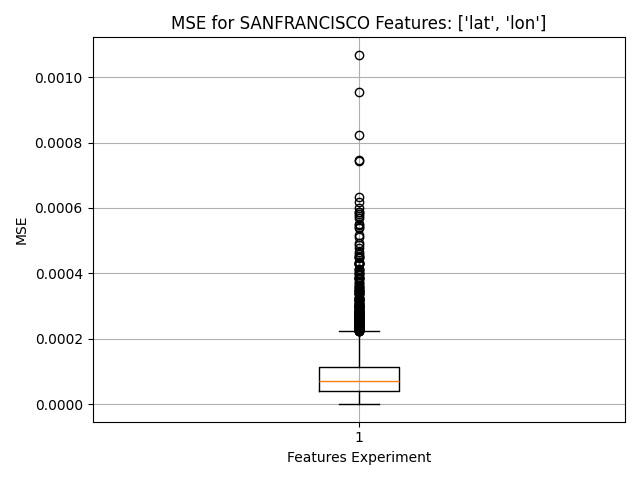

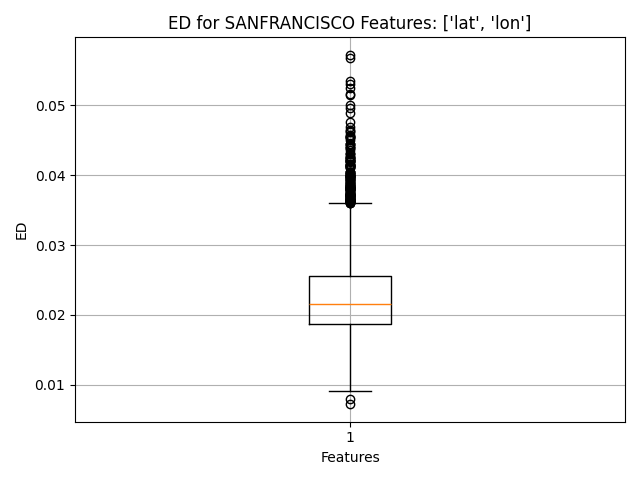

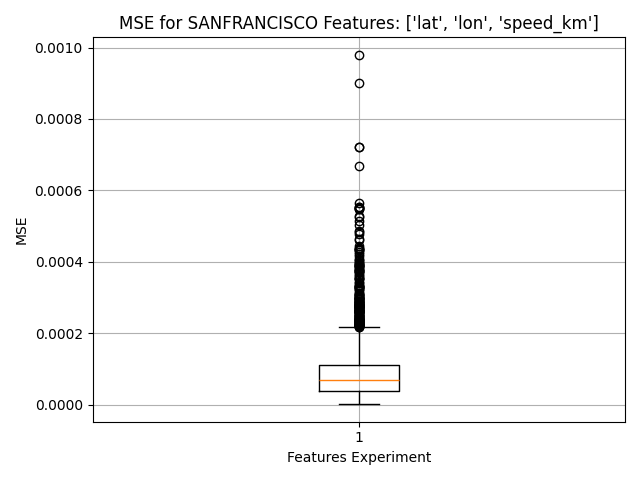

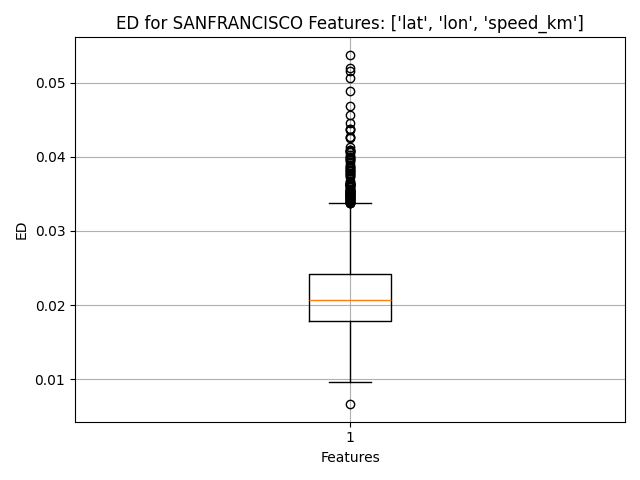

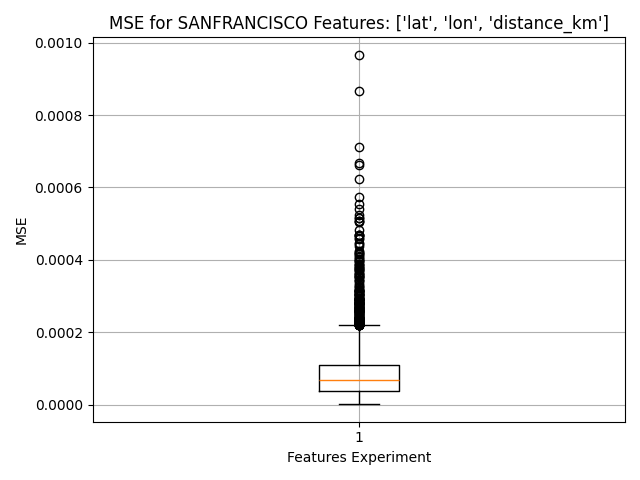

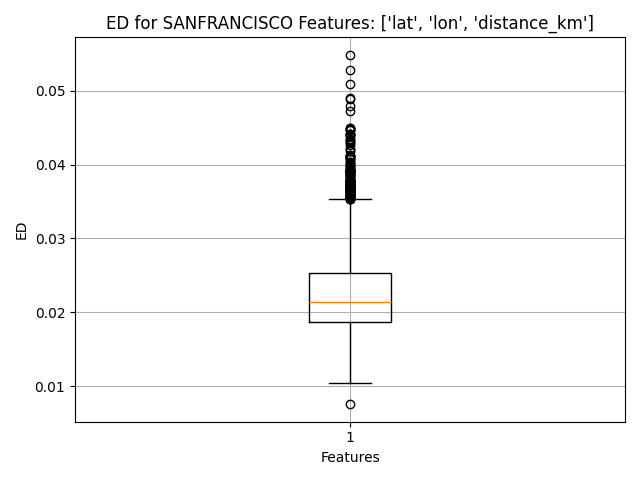

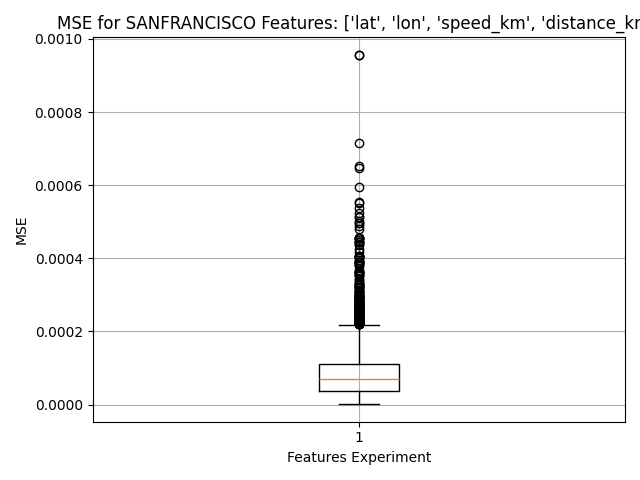

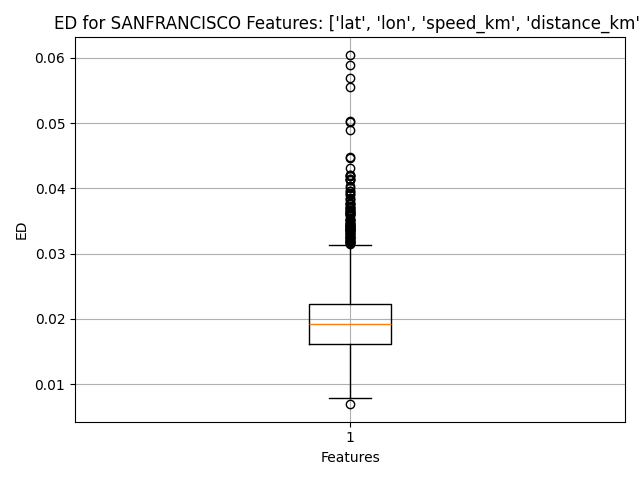

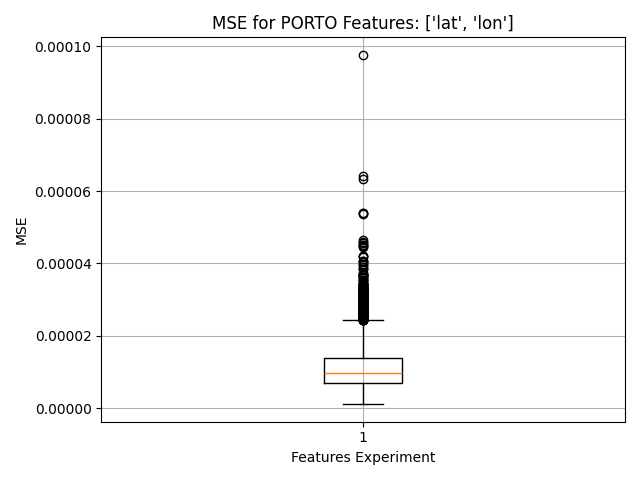

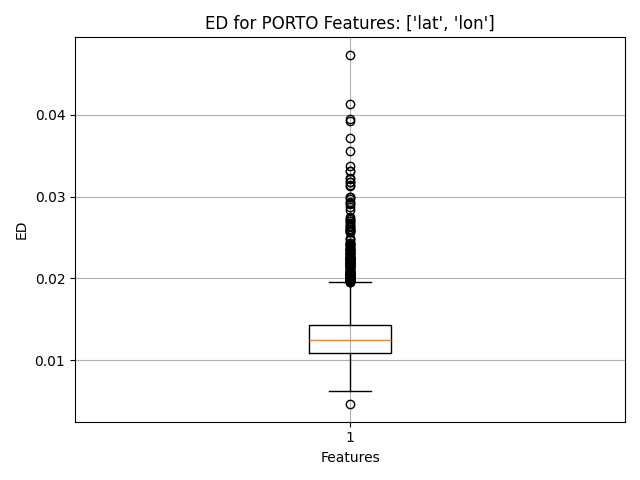

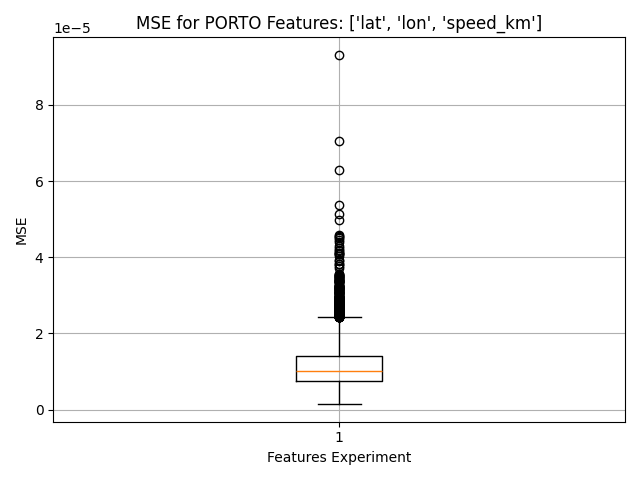

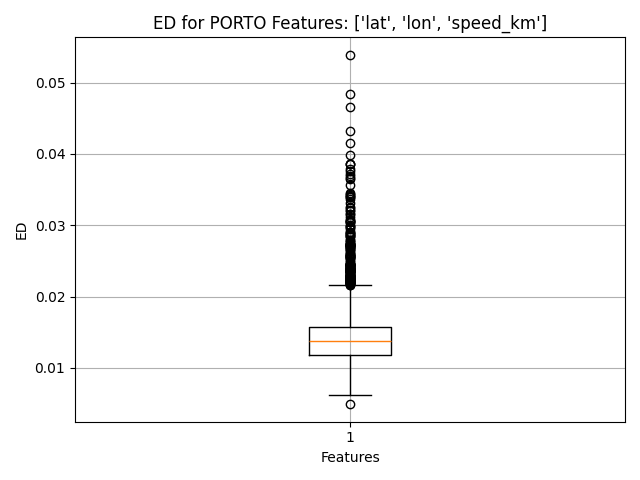

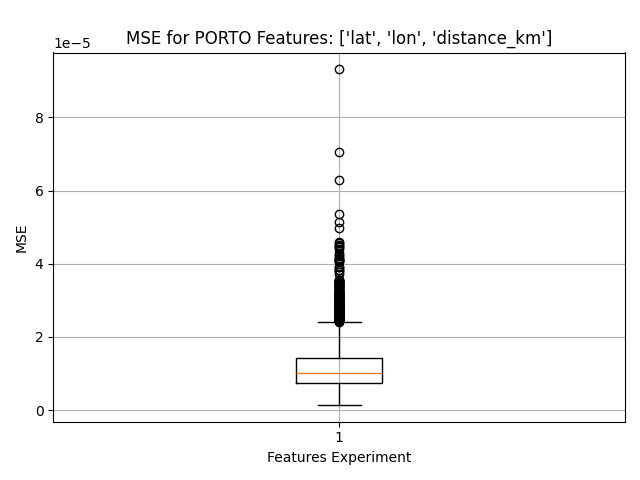

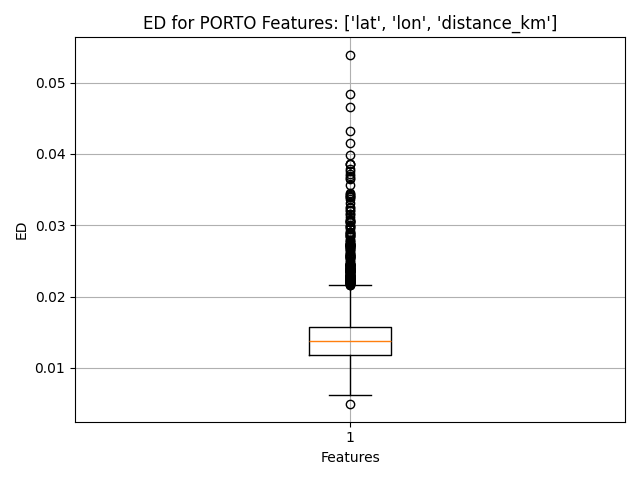

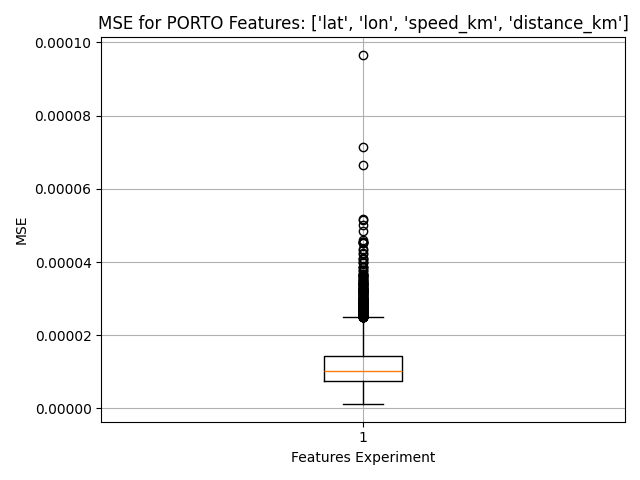

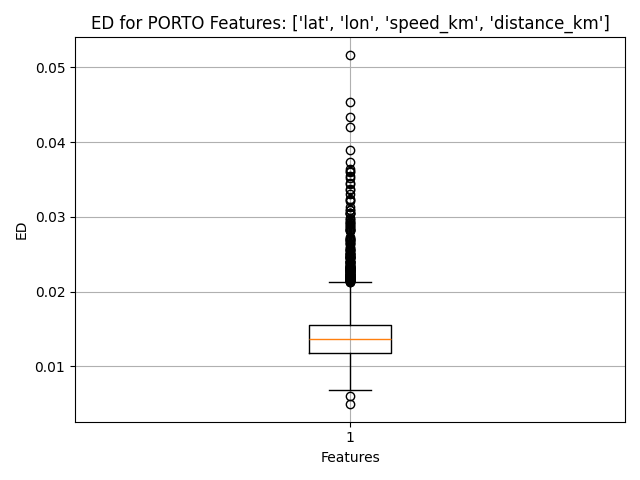

In [113]:
# Plot the average and std of the MSE and ED for each dataset and features
for sel_ds in ["SANFRANCISCO", "PORTO"]:
    
    SELECTED_DATASET = sel_ds
    
    # Paths for the features and plots
    path_features = "pkl/FEATURES/" + SELECTED_DATASET + "/"
    path_plots = "plots/" + SELECTED_DATASET + "/"
            
    results_num_feats_metrics = load_data_from_pickle("pkl/FEATURES/" + SELECTED_DATASET + "/results_num_feats_metrics.pkl")
    results_num_feats_preds = load_data_from_pickle("pkl/FEATURES/" + SELECTED_DATASET + "/results_num_feats_preds.pkl")
    results_num_feats_actuals = load_data_from_pickle("pkl/FEATURES/" + SELECTED_DATASET + "/results_num_feats_actuals.pkl")
    
    mse_values = []
    ed_values = []
    for i in range(0, len(COLUMNS_LIST)):
        results = results_num_feats_metrics
        mse_values.append(results[str(COLUMNS_LIST[i])]["MSE"])
        ed_values.append(results[str(COLUMNS_LIST[i])]["ED"])
    
    mse_values = np.array(mse_values)   
    ed_values = np.array(ed_values)
    for i in range(0, len(COLUMNS_LIST)):
        
        plt.figure()
        plt.title("MSE for " + str(sel_ds) + " Features: " + str(COLUMNS_LIST[i]))
        plt.boxplot(mse_values[i])
        plt.grid(True)
        plt.xlabel("Features Experiment")
        plt.ylabel("MSE")
        # plt.legend(COLUMNS_LIST[i])
        plt.tight_layout()
        plt.savefig(path_plots + "MSE_" + str(sel_ds) + " " + str(COLUMNS_LIST[i]) + ".pdf")

        ed_values = np.array(ed_values)
        plt.figure()
        plt.title("ED for " + str(sel_ds) + " Features: " + str(COLUMNS_LIST[i]))
        plt.boxplot(ed_values[i])
        plt.grid(True)
        plt.xlabel("Features")
        plt.ylabel("ED")
        # plt.legend(COLUMNS_LIST[i])
        plt.tight_layout()
        plt.savefig(path_plots + "ED_" + str(sel_ds)+ " " + str(COLUMNS_LIST[i]) +".pdf")


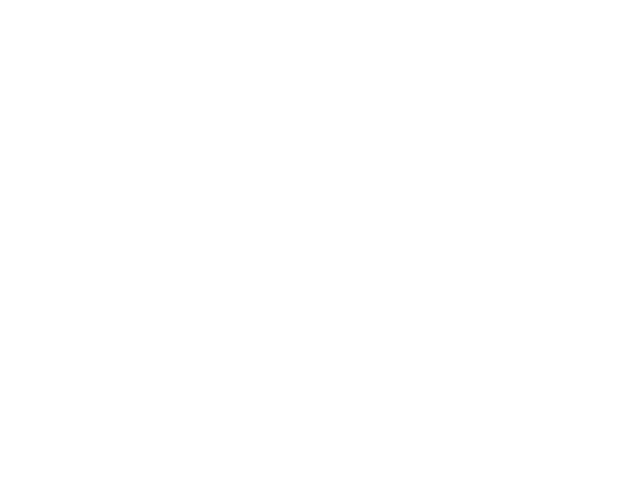

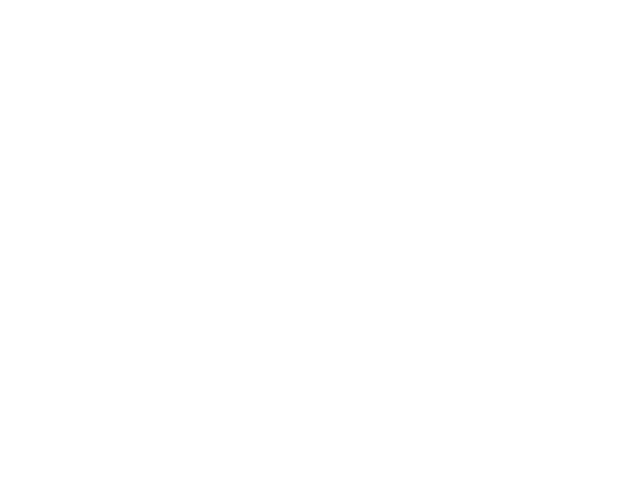

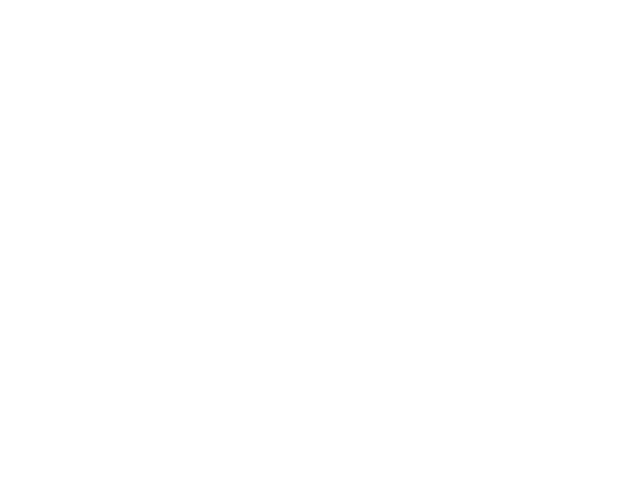

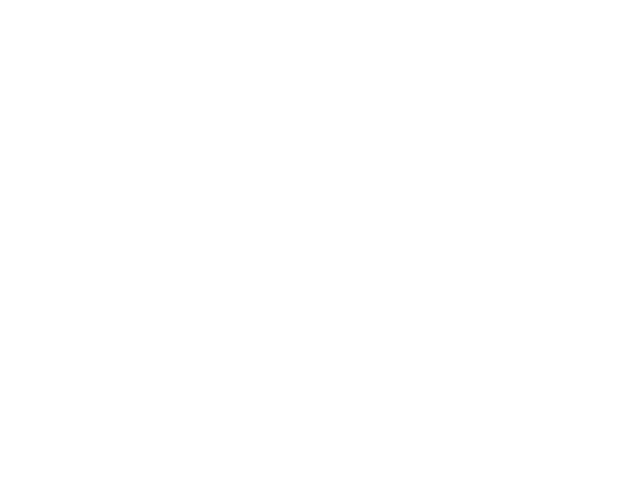

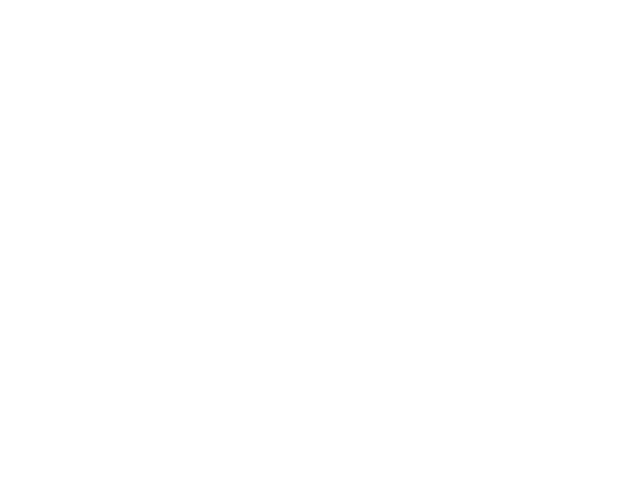

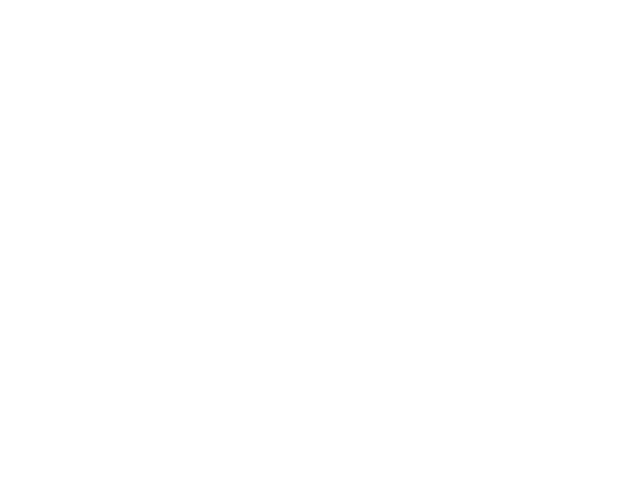

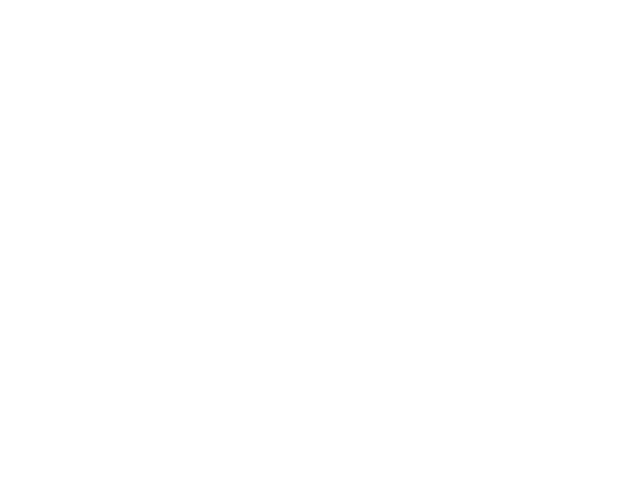

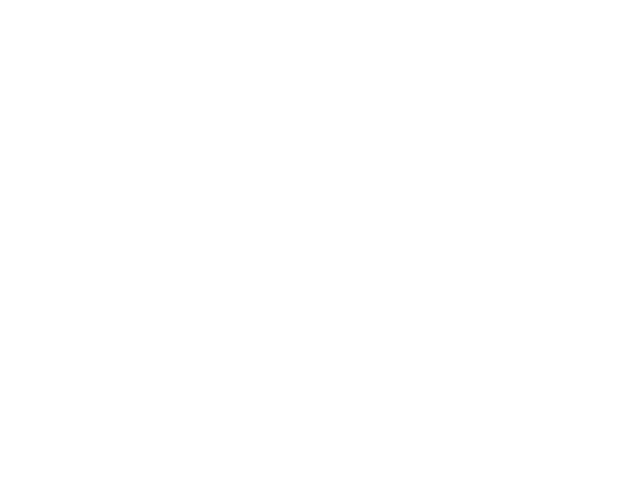

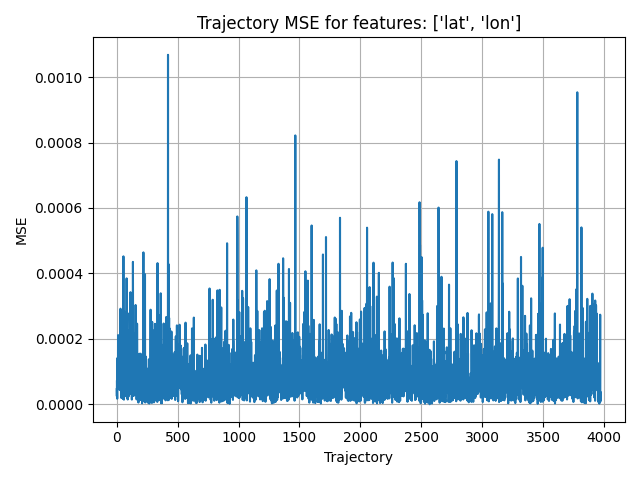

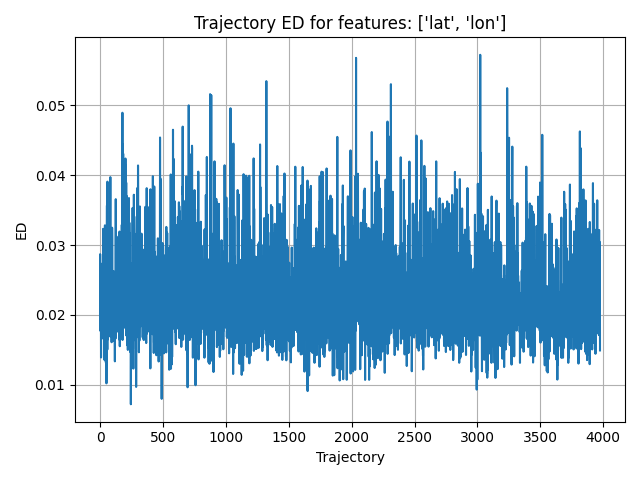

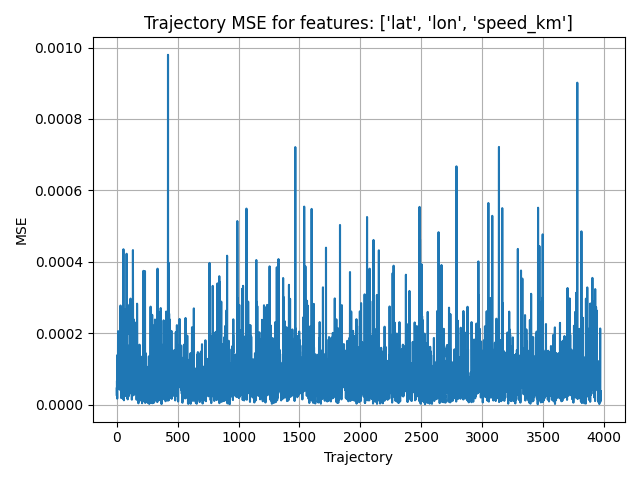

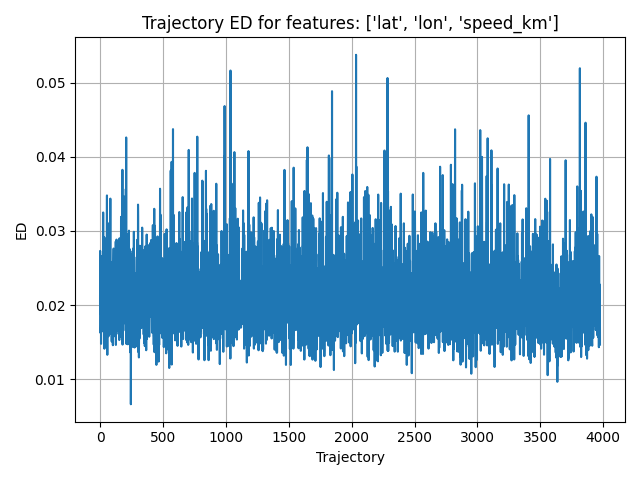

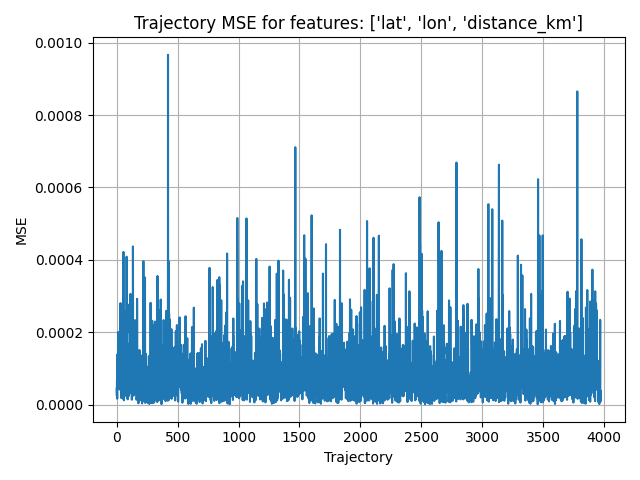

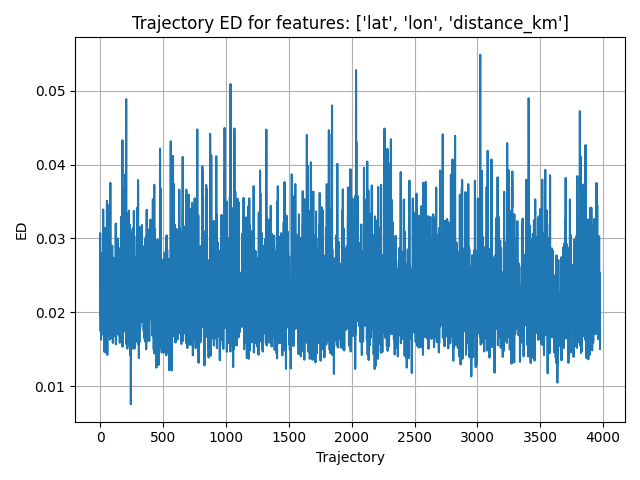

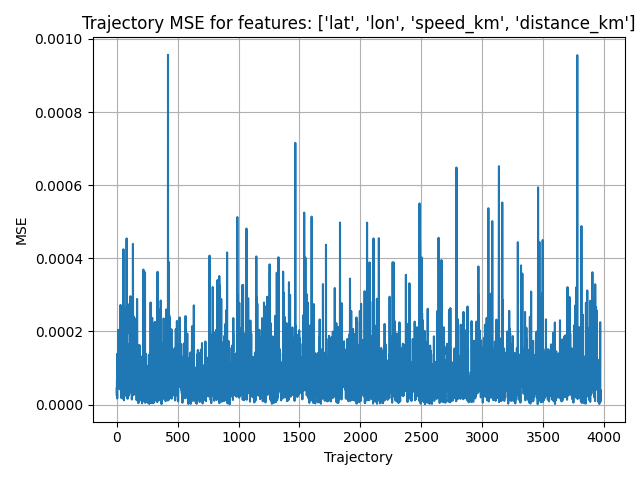

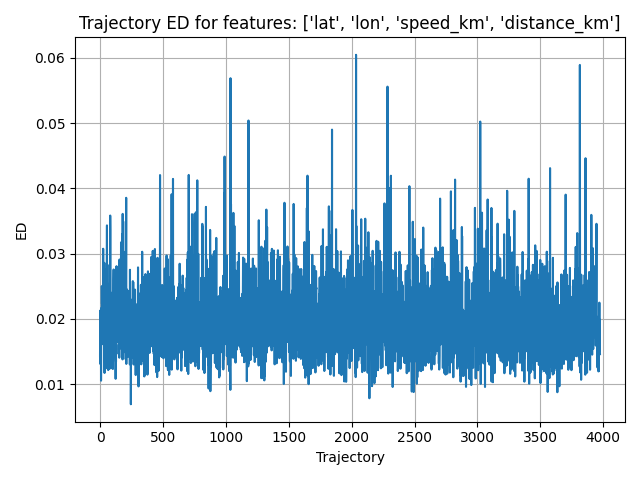

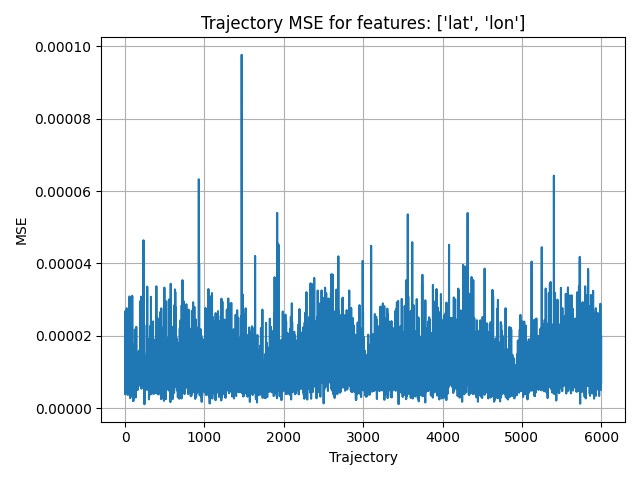

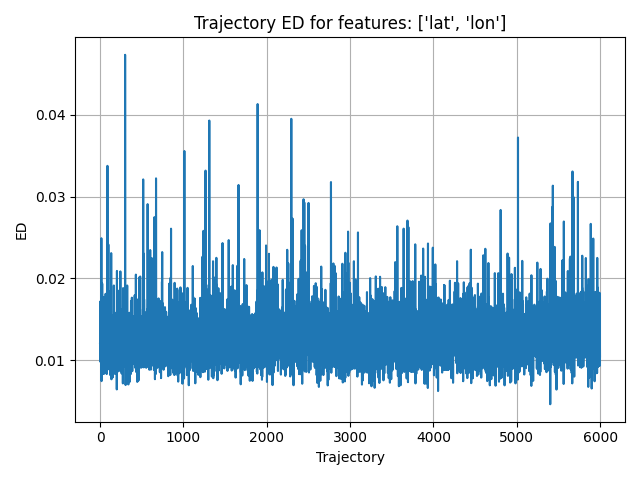

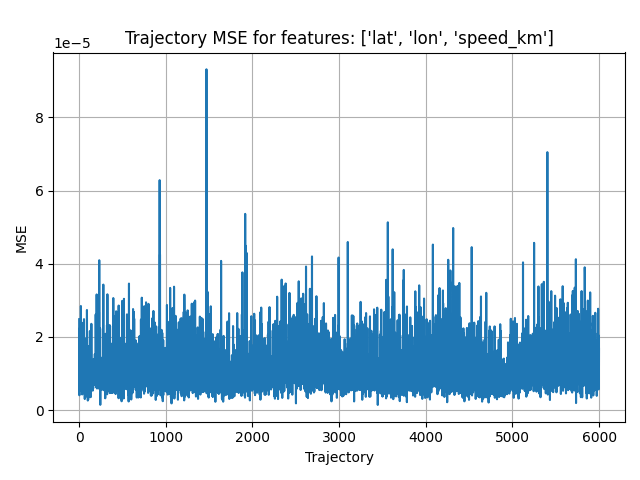

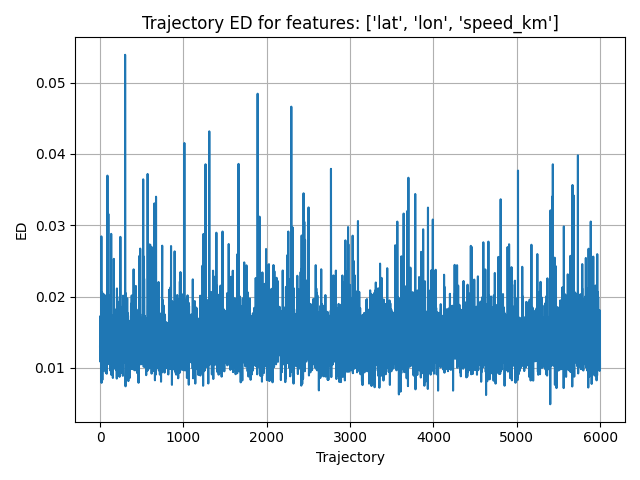

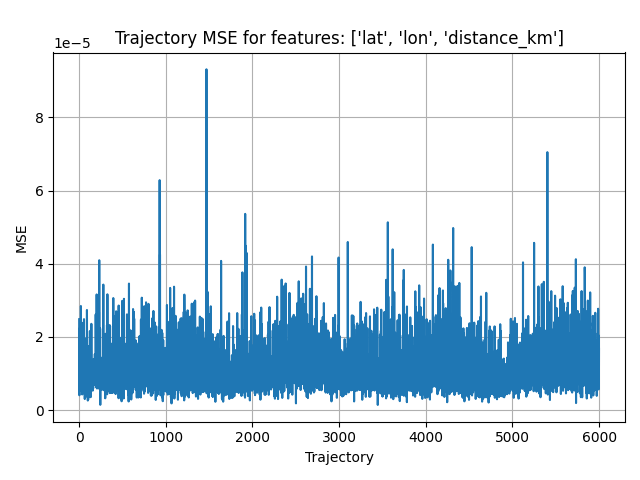

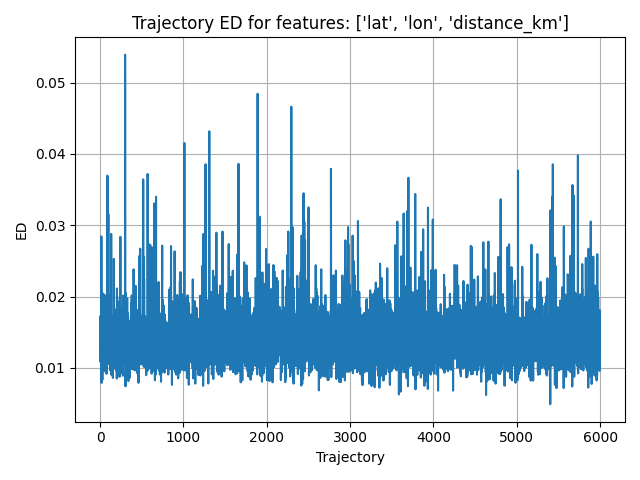

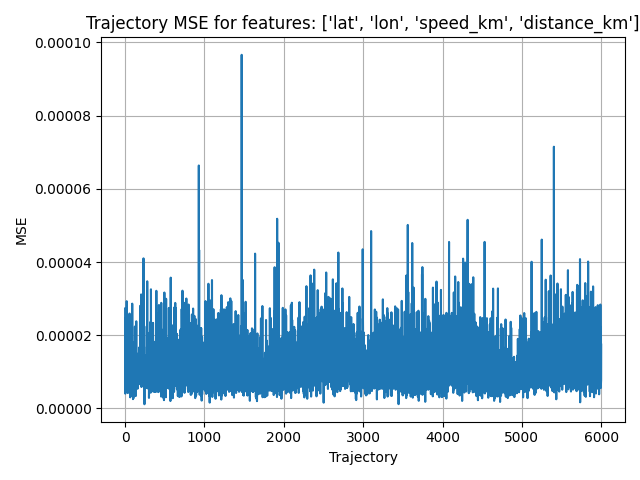

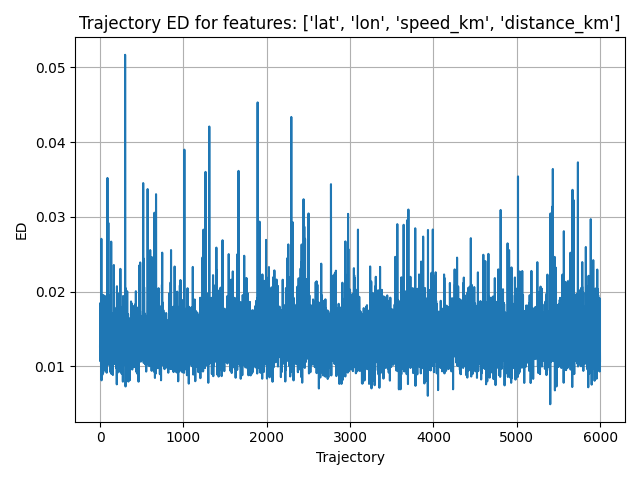

In [108]:
# Plot the actual MSE, ED, and predictions for each dataset and features
START_FOR_METRICS = 0
END_FOR_METRICS = 6000 # 6000

START_FOR_PREDICTIONS = 0
END_FOR_PREDICTIONS = 20 # 6000

# If you want to plot only a part of the trajectory, set the lon and lat ranges (x_range and y_range)
X_RANGE = None
Y_RANGE = None

for sel_ds in ["SANFRANCISCO", "PORTO"]:
    SELECTED_DATASET = sel_ds
    # Paths for the features and plots
    path_features = "pkl/FEATURES/" + SELECTED_DATASET + "/"
    path_plots = "plots/" + SELECTED_DATASET + "/"
            
    results_num_feats_metrics = load_data_from_pickle("pkl/FEATURES/" + SELECTED_DATASET + "/results_num_feats_metrics.pkl")
    results_num_feats_preds = load_data_from_pickle("pkl/FEATURES/" + SELECTED_DATASET + "/results_num_feats_preds.pkl")
    results_num_feats_actuals = load_data_from_pickle("pkl/FEATURES/" + SELECTED_DATASET + "/results_num_feats_actuals.pkl")
    
    for i in range(0, len(COLUMNS_LIST)):

        results_1 = results_num_feats_metrics[str(COLUMNS_LIST[i])]
        results_2 = results_num_feats_preds[str(COLUMNS_LIST[i])]
        results_3 = results_num_feats_actuals[str(COLUMNS_LIST[i])]
        
        # Plot metrics
        plt.figure()
        plt.grid(True)
        plt.title("Trajectory MSE for features: " + str(COLUMNS_LIST[i]))
        plt.plot(results_1["MSE"][START_FOR_METRICS:END_FOR_METRICS])
        plt.xlabel("Trajectory")
        plt.ylabel("MSE")
        plt.tight_layout()
        plt.savefig(path_plots + "S2S_MSE" + str(COLUMNS_LIST[i]) + ".pdf")

        plt.figure()
        plt.grid(True)
        plt.title("Trajectory ED for features: " + str(COLUMNS_LIST[i]))
        plt.plot(results_1["ED"][START_FOR_METRICS:END_FOR_METRICS])
        plt.xlabel("Trajectory")
        plt.ylabel("ED")
        plt.tight_layout()
        plt.savefig(path_plots +  "S2S_ED" + str(COLUMNS_LIST[i]) + ".pdf")
        
        # Plot predictions
        plot_act_pred_traj_one_by_one(actual = results_3,
                                    predicted = results_2,
                                    seq_len = SEQ_LEN,
                                    num_of_traj_to_plot = 20,
                                    start_traj = START_FOR_PREDICTIONS,
                                    end_traj = END_FOR_PREDICTIONS, 
                                    k=1,
                                    x_range=X_RANGE,
                                    y_range=Y_RANGE,
                                    scatter=True,
                                    path=path_plots,
                                    info = str(COLUMNS_LIST[i]))

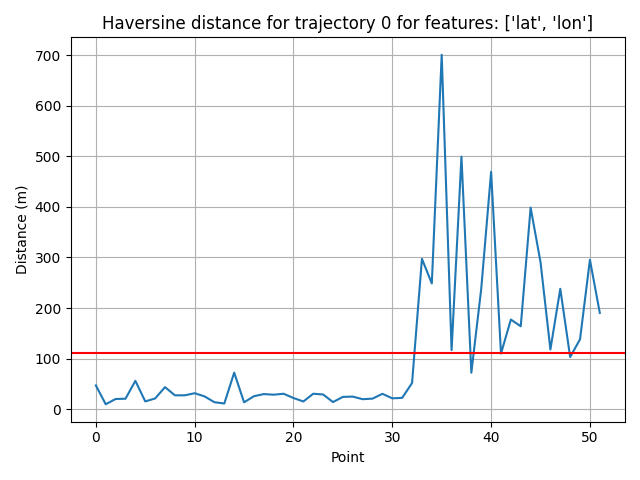

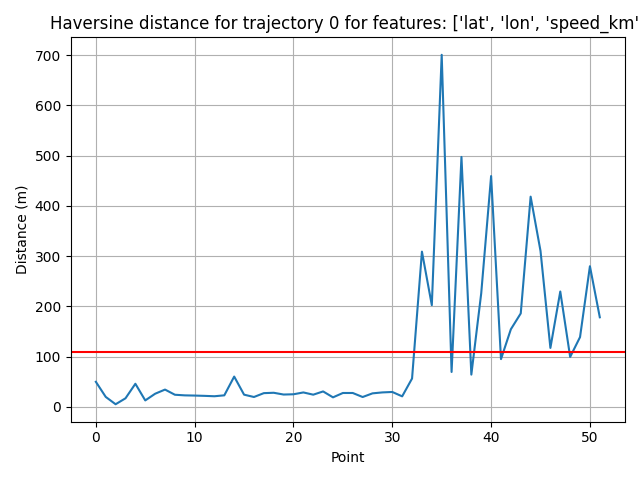

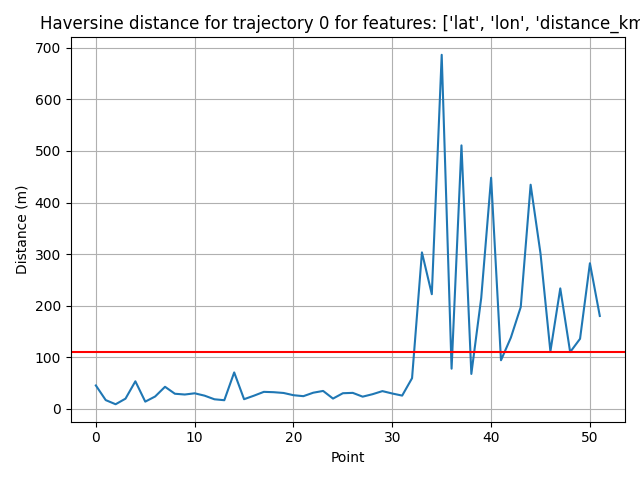

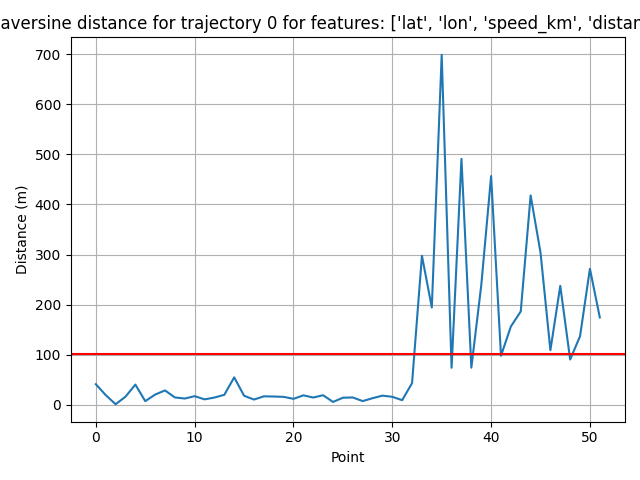

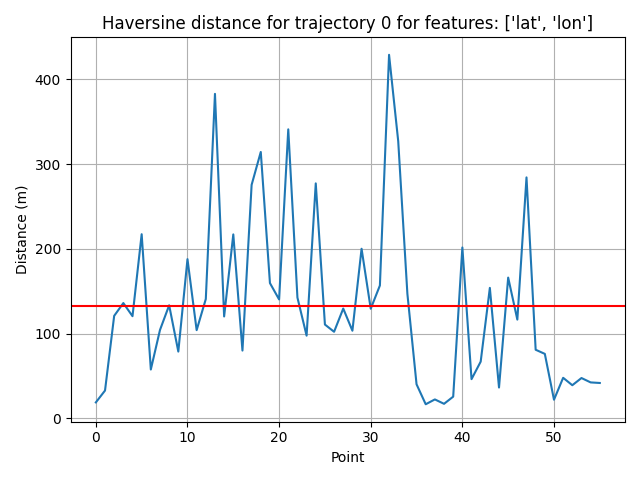

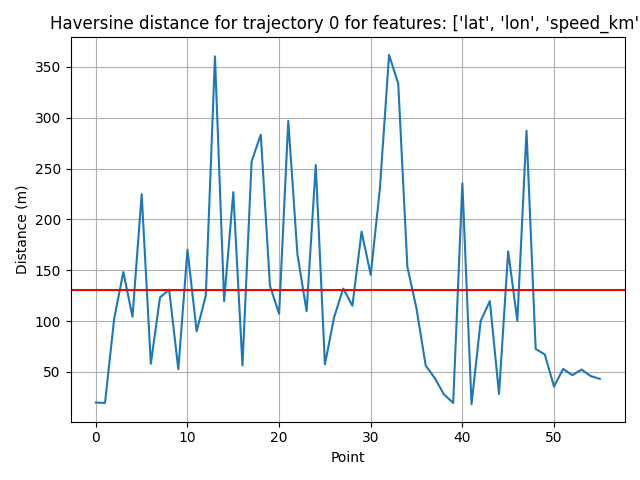

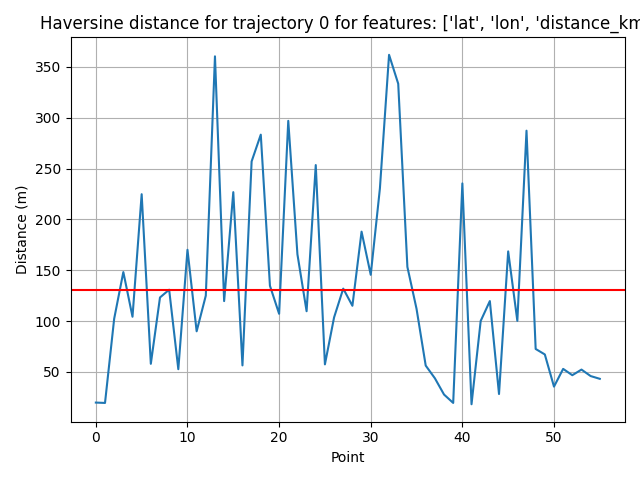

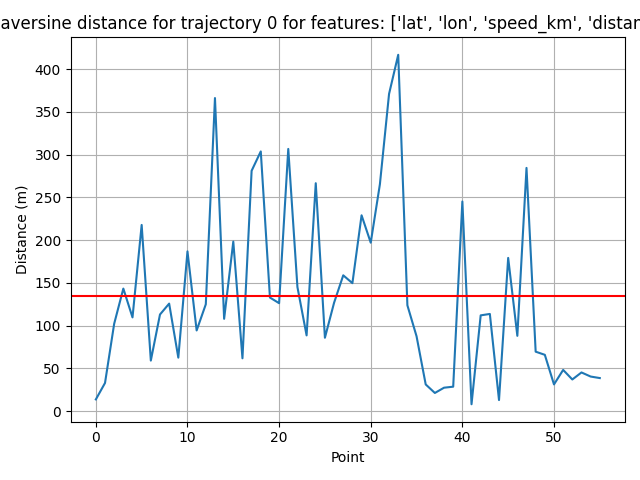

In [75]:
# Plot the Haversine distance for each dataset and features
traj_id = 0

for sel_ds in ["SANFRANCISCO", "PORTO"]:
    SELECTED_DATASET = sel_ds
    # Paths for the features and plots
    path_features = "pkl/FEATURES/" + SELECTED_DATASET + "/"
    path_plots = "plots/" + SELECTED_DATASET + "/"
            
    results_num_feats_metrics = load_data_from_pickle("pkl/FEATURES/" + SELECTED_DATASET + "/results_num_feats_metrics.pkl")
    results_num_feats_preds = load_data_from_pickle("pkl/FEATURES/" + SELECTED_DATASET + "/results_num_feats_preds.pkl")
    results_num_feats_actuals = load_data_from_pickle("pkl/FEATURES/" + SELECTED_DATASET + "/results_num_feats_actuals.pkl")
    
    for i in range(0, len(COLUMNS_LIST)):

        results_1 = results_num_feats_metrics[str(COLUMNS_LIST[i])]
        preds = results_num_feats_preds[str(COLUMNS_LIST[i])]
        actuals = results_num_feats_actuals[str(COLUMNS_LIST[i])]
        
        # Test Actual Map Distance
        actual = actuals[traj_id]
        predicted = preds[traj_id]

        dists = compute_point_to_point_haversine_distances(actual, predicted)

        plt.figure()
        plt.plot(dists)
        plt.title("Haversine distance for trajectory " + str(traj_id) + " for features: " + str(COLUMNS_LIST[i]))
        plt.xlabel("Point")
        plt.ylabel("Distance (m)")
        plt.axhline(y=np.mean(dists), color='r', linestyle='-')
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(path_plots + "Haversine_distance_" + str(traj_id) + ".pdf")

In [1]:
import tensorflow as tf
import os


# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
tf.config.list_physical_devices('GPU')

2025-05-27 11:07:27.389265: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-27 11:07:27.425016: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748333247.434426 3463729 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748333247.437037 3463729 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1748333247.444690 3463729 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]